<a href="https://colab.research.google.com/github/Luis-Menezes/CI-Chemistry/blob/main/HandsOn_DataClustering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Chemistry - Hands on Data Clustering Molecules
### Luis Filipe C. de Menezes - RA: 164924
This is part of an assignment for the Computational Intelligence in Chemistry course on UNIFESP's masters program.

This notebook must use data from QM9 to do the following:

I. Extract any simple descriptors from the SMILES
representation, e.g.,

- Physical/Chemical descriptors (molecular mass,
etc.), RDKit descriptors, Mordred, etc. (do not
consider geometry for this task)

II. Using the feature vector, perform data
clustering with at leas two algorithms (select
algorithms with distinct approaches)

- E.g., K-Means and DBScan

III. Use one internal and one external measure to
evaluate the clusters
- Internal: Silhouette
- External: any property

IV. Evaluate the clustering for several parameters
(K, Epsilon, minPts, etc.)

## Needed packages

In [1]:
!pip install --quiet rdkit
!pip install --quiet mordred

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem

## Load and unpack QM9 dataset

In [3]:
!wget -O data.xyz.tar.bz2 https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d&st=1cohswqh&dl=0

--2025-09-29 16:30:33--  https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5005065aebe9f89988c3531baf.dl.dropboxusercontent.com/cd/0/inline/CyR4uFu88knoZxjS3KNbYve60jGLG-SU7Z0LIFIzcDwfVZ7VMXy9_NdAW1bmy_j8Fl1sHTTFHErxpykG6xzFMFhF_aw9kUTXHHTak8KoQ5Y3WlpSwH2MlCO3SpnHad4j6cLX-IaNzwE2y3DZpqQJJDOk/file# [following]
--2025-09-29 16:30:33--  https://uc5005065aebe9f89988c3531baf.dl.dropboxusercontent.com/cd/0/inline/CyR4uFu88knoZxjS3KNbYve60jGLG-SU7Z0LIFIzcDwfVZ7VMXy9_NdAW1bmy_j8Fl1sHTTFHErxpykG6xzFMFhF_aw9kUTXHHTak8KoQ5Y3WlpSwH2MlCO3SpnHad4j6cLX-IaNzwE2y3DZpqQJJDOk/file
Resolving uc5005065aebe9f89988c3531baf.dl.dropboxusercontent.com (uc5005065aebe9f89988c3531baf.dl.dropboxusercontent.com)... 162.125.5.1

In [4]:
!mkdir qm9_files
!tar -xjf /content/data.xyz.tar.bz2 -C /content/qm9_files/

## Open XYZ files and extract the properties and SMILES

In [5]:
qm9_folder = 'qm9_files/'
QM9_PROPERTIES = [
    "A", 'B', 'C', 'mu', 'alpha',
    'homo', 'lumo', 'gap', 'r2',
    'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]

with open(qm9_folder+'dsgdb9nsd_113885.xyz') as file:
  for line in file:
    print(line)

19

gdb 113885	3.70802	0.80999	0.7081	2.6975	73.65	-0.2639	0.0141	0.278	1593.5236	0.156316	-460.174889	-460.164623	-460.163679	-460.212278	35.326	

C	-0.008898706	 1.435343511	-0.1229342875	-0.480889

C	-0.097211668	-0.0611740136	 0.0533750899	 0.431334

O	-0.522805097	-0.6329577977	 1.0223608396	-0.34442

O	 0.3874153201	-0.692641184	-1.0454419183	-0.247509

C	 0.3502508225	-2.1099666389	-1.0216443391	 0.118249

C	-0.6452778548	-2.8049992501	-1.9010293635	-0.305338

C	 0.8299955957	-2.806393386	-2.257736521	-0.04378

C	 1.3090797685	-2.0281448361	-3.4552388748	-0.093611

O	 1.0953742585	-2.8320000843	-4.6085691448	-0.419869

H	-0.3728027153	 1.9278328937	 0.7777832851	 0.149542

H	 1.0248947898	 1.7315350968	-0.3210999853	 0.149596

H	-0.6070917791	 1.7459702376	-0.9844780335	 0.149165

H	 0.576972916	-2.5190329042	-0.0453019279	 0.12476

H	-1.1102986284	-3.7153217605	-1.5406769745	 0.122235

H	-1.2860640388	-2.1730656326	-2.5065209428	 0.123942

H	 1.3703384329	-3.7344941519	-2.09474

### I. Extracting physical descriptors
Using Mordred and RDKit to extract descriptors.

**Mordred** is a high-performance Python package for calculating over 1,800 2D and 3D molecular descriptors. These descriptors serve as numerical features representing a molecule's structure, which are essential for developing machine learning models like QSPR and QSAR. Built on RDKit, it's designed for speed and can be used as a command-line tool or directly within a Python script, offering flexibility for data processing pipelines.

Could have used the function numHDonors and numHAcceptors but wanted to see how Mordred works.

Quick description of used descriptors:
- **BasicGroupCount**: counts how many basic groups (H+ receivers) are in the molecule.
- **AcidicGroupCount**: counts how many acidic groups (H+ donators) are in the molecule.
- **Chi0**: molecular descriptor that represents the zero-order atomic connectivity index of a molecule.
- **MolLogP**:
- **RingCount**: counts how many rings are in the molecule.







In [6]:
from mordred import AcidBase
from rdkit.Chem.Descriptors import Chi0, MolLogP, MolWt, RingCount, TPSA, FractionCSP3, Phi

def calculate_descriptors(molecule):
  base_gc = AcidBase.BasicGroupCount()
  acid_gc = AcidBase.AcidicGroupCount()
  chi = Chi0(molecule)
  logp = MolLogP(molecule)
  mw = MolWt(molecule)
  ring_count = RingCount(molecule)
  tpsa = TPSA(molecule)
  csp3 = FractionCSP3(molecule)
  phi = Phi(molecule)

  return {str(base_gc): base_gc(molecule),
          str(acid_gc): acid_gc(molecule),
          "RingCount": ring_count,
          "Chi0": chi,
          "MolLogP": logp,
          "MolWt": mw,
          "TPSA": tpsa,
          "Fraction CSP3": csp3,
          "Phi": phi}


if __name__ == '__main__':
  with open(qm9_folder+'dsgdb9nsd_113885.xyz', 'r') as file:
      lines = file.readlines()
      print("Test Smiles:", lines[22].split()[0])
      mol = Chem.MolFromSmiles(lines[22].split()[0])
      print(calculate_descriptors(mol))

Test Smiles: CC(=O)OC1CC1CO
{'nBase': 0, 'nAcid': 0, 'RingCount': 1, 'Chi0': 6.8533711511285205, 'MolLogP': -0.06970000000000004, 'MolWt': 130.143, 'TPSA': 46.53, 'Fraction CSP3': 0.8333333333333334, 'Phi': 1.7109047903148478}


In [7]:
def load_validate_mol(file):
  with open(file, 'r') as file:
    n_atoms = int(file.readline())

    properties_list = file.readline().split()
    mol_id = properties_list[1]
    properties_values = [float(prop) for prop in properties_list[2:]]

    atoms = []
    for nlines in range(n_atoms):
      atom = file.readline().split()
      atoms.append(atom[0]) # get only the the atom string

      # Since we doesn't need coordinates for this assignment, we will ignore it for now
      # atom_coords = atom[1:3]
      # atom_coords = [float(coord) for coord in atom_coords]
      # print(atom)
    # print(atoms)
    file.readline() # ignores the frequencies

    smiles_list = file.readline().split()
    properties_dict = dict(zip(QM9_PROPERTIES, properties_values))


    mol = Chem.MolFromSmiles(smiles_list[0]) # If it's None then smiles is invalid
    if mol is None:
        print("Invalid smiles for arquive: ", mol_id)
        return
    canon_smiles = Chem.CanonSmiles(smiles_list[0])
    descriptors = calculate_descriptors(mol)
    properties_dict.update(descriptors)

    molecule_data = {
                'id': mol_id,
                'n_atoms': n_atoms,
                'atom_list': atoms,
                'smiles': canon_smiles
            }
            # Adiciona as 12 propriedades ao dicionário principal
    molecule_data.update(properties_dict)
    return molecule_data


def get_full_dataset(folder):
  dataset_list = []
  # print(f"Lendo arquivos da pasta: {folder}")

  files_to_process = [f for f in os.listdir(folder) if f.endswith('.xyz')]
  for i, file in enumerate(files_to_process):

      if (i + 1) % 10000 == 0:
          print(f"  Processando arquivo {i+1}/{len(files_to_process)}...")

      file_path = os.path.join(folder, file)

      # Chama a função de processamento para um arquivo
      molecule_data = load_validate_mol(file_path)

      # Se a função retornou dados válidos (não None), adiciona à lista
      if molecule_data:
          dataset_list.append(molecule_data)

      else:
        print("Couldn't proccess file:", file_path)
  return dataset_list




if __name__ == '__main__':
  full_dataset = get_full_dataset(qm9_folder)

  df = pd.DataFrame(full_dataset)
  # load_validate_mol(qm9_folder+'dsgdb9nsd_113885.xyz')

  Processando arquivo 10000/133885...
  Processando arquivo 20000/133885...
  Processando arquivo 30000/133885...
  Processando arquivo 40000/133885...
  Processando arquivo 50000/133885...
  Processando arquivo 60000/133885...
  Processando arquivo 70000/133885...
  Processando arquivo 80000/133885...
  Processando arquivo 90000/133885...
  Processando arquivo 100000/133885...
  Processando arquivo 110000/133885...
  Processando arquivo 120000/133885...
  Processando arquivo 130000/133885...


In [8]:
df.head()

,id,n_atoms,atom_list,smiles,A,B,C,mu,alpha,homo,...,Cv,nBase,nAcid,RingCount,Chi0,MolLogP,MolWt,TPSA,Fraction CSP3,Phi
0,18886,17,"[C, C, O, C, C, C, N, C, H, H, H, H, H, H, H, ...",C1C2CN3CC(O2)C13,3.40459,2.78757,2.55839,0.7878,66.10,-0.2082,...,22.899,1,0,3,5.137828,-0.15830,111.144,12.47,1.0,0.460986
1,56568,16,"[N, C, C, O, C, N, C, N, O, H, H, H, H, H, H, H]",N#CC(O)C(N)C(N)=O,2.90472,1.16272,0.85736,3.7568,66.18,-0.2518,...,34.752,1,0,0,7.439158,-2.31652,129.119,113.13,0.5,2.641197
2,18086,20,"[O, C, C, C, C, C, C, C, H, H, H, H, H, H, H, ...",OCCC1C2CCC12,4.56556,1.09712,1.06425,1.4445,74.69,-0.2500,...,30.821,0,0,2,5.560478,1.02480,112.172,20.23,1.0,0.883725
3,54238,15,"[N, C, O, C, N, C, O, C, O, H, H, H, H, H, H]",NC(=O)C1(N)COC1=O,2.41355,1.51701,1.28299,1.7223,61.37,-0.2492,...,31.497,1,0,1,7.068914,-2.27400,130.103,95.41,0.5,0.966501
4,96660,18,"[C, N, C, C, N, C, N, C, O, H, H, H, H, H, H, ...",CN=C(C)NC(=N)C=O,2.56809,1.14904,0.83510,4.8797,81.91,-0.2408,...,35.167,3,0,0,7.276021,-0.19963,127.147,65.31,0.4,3.270437


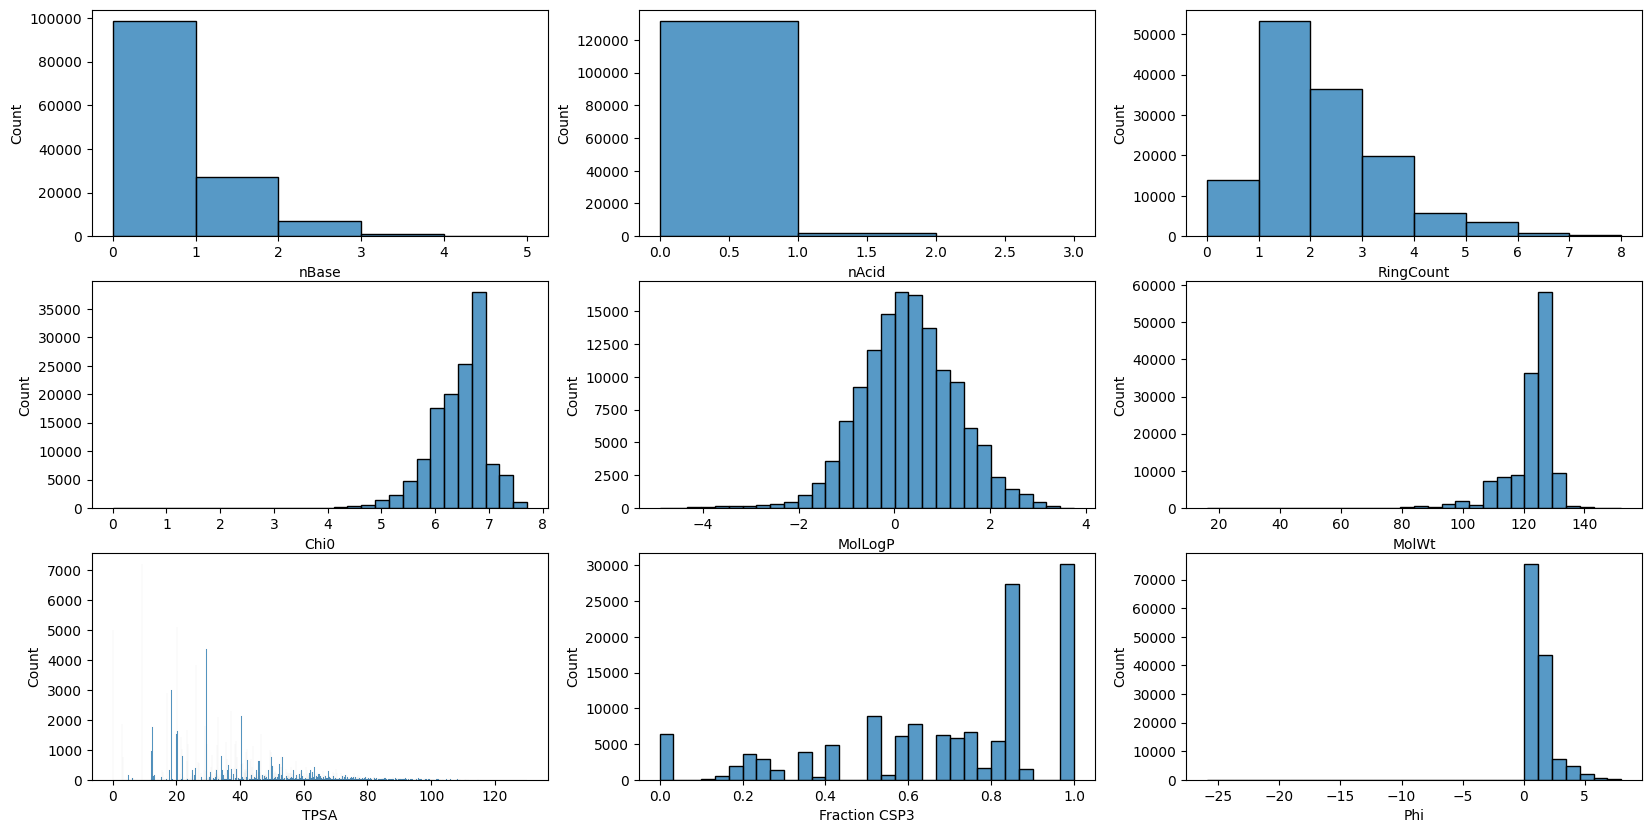

In [18]:
import math
axis, fig = plt.subplots(3, 3, figsize=(20, 10))
sns.histplot(df['nBase'], binwidth=1, ax=fig[0][0])
sns.histplot(df['nAcid'], binwidth=1, ax=fig[0][1])
sns.histplot(df['RingCount'], binwidth=1, ax=fig[0][2])
sns.histplot(df['Chi0'], bins=30, ax=fig[1][0])
sns.histplot(df['MolLogP'], bins=30, ax=fig[1][1])
sns.histplot(df['MolWt'], bins=30, ax=fig[1][2])
sns.histplot(df['TPSA'], binwidth=0.1, ax=fig[2][0])
sns.histplot(df['Fraction CSP3'], bins=30, ax=fig[2][1])
sns.histplot(df['Phi'], bins=30, ax=fig[2][2])
plt.show()

<Figure size 1500x3000 with 0 Axes>

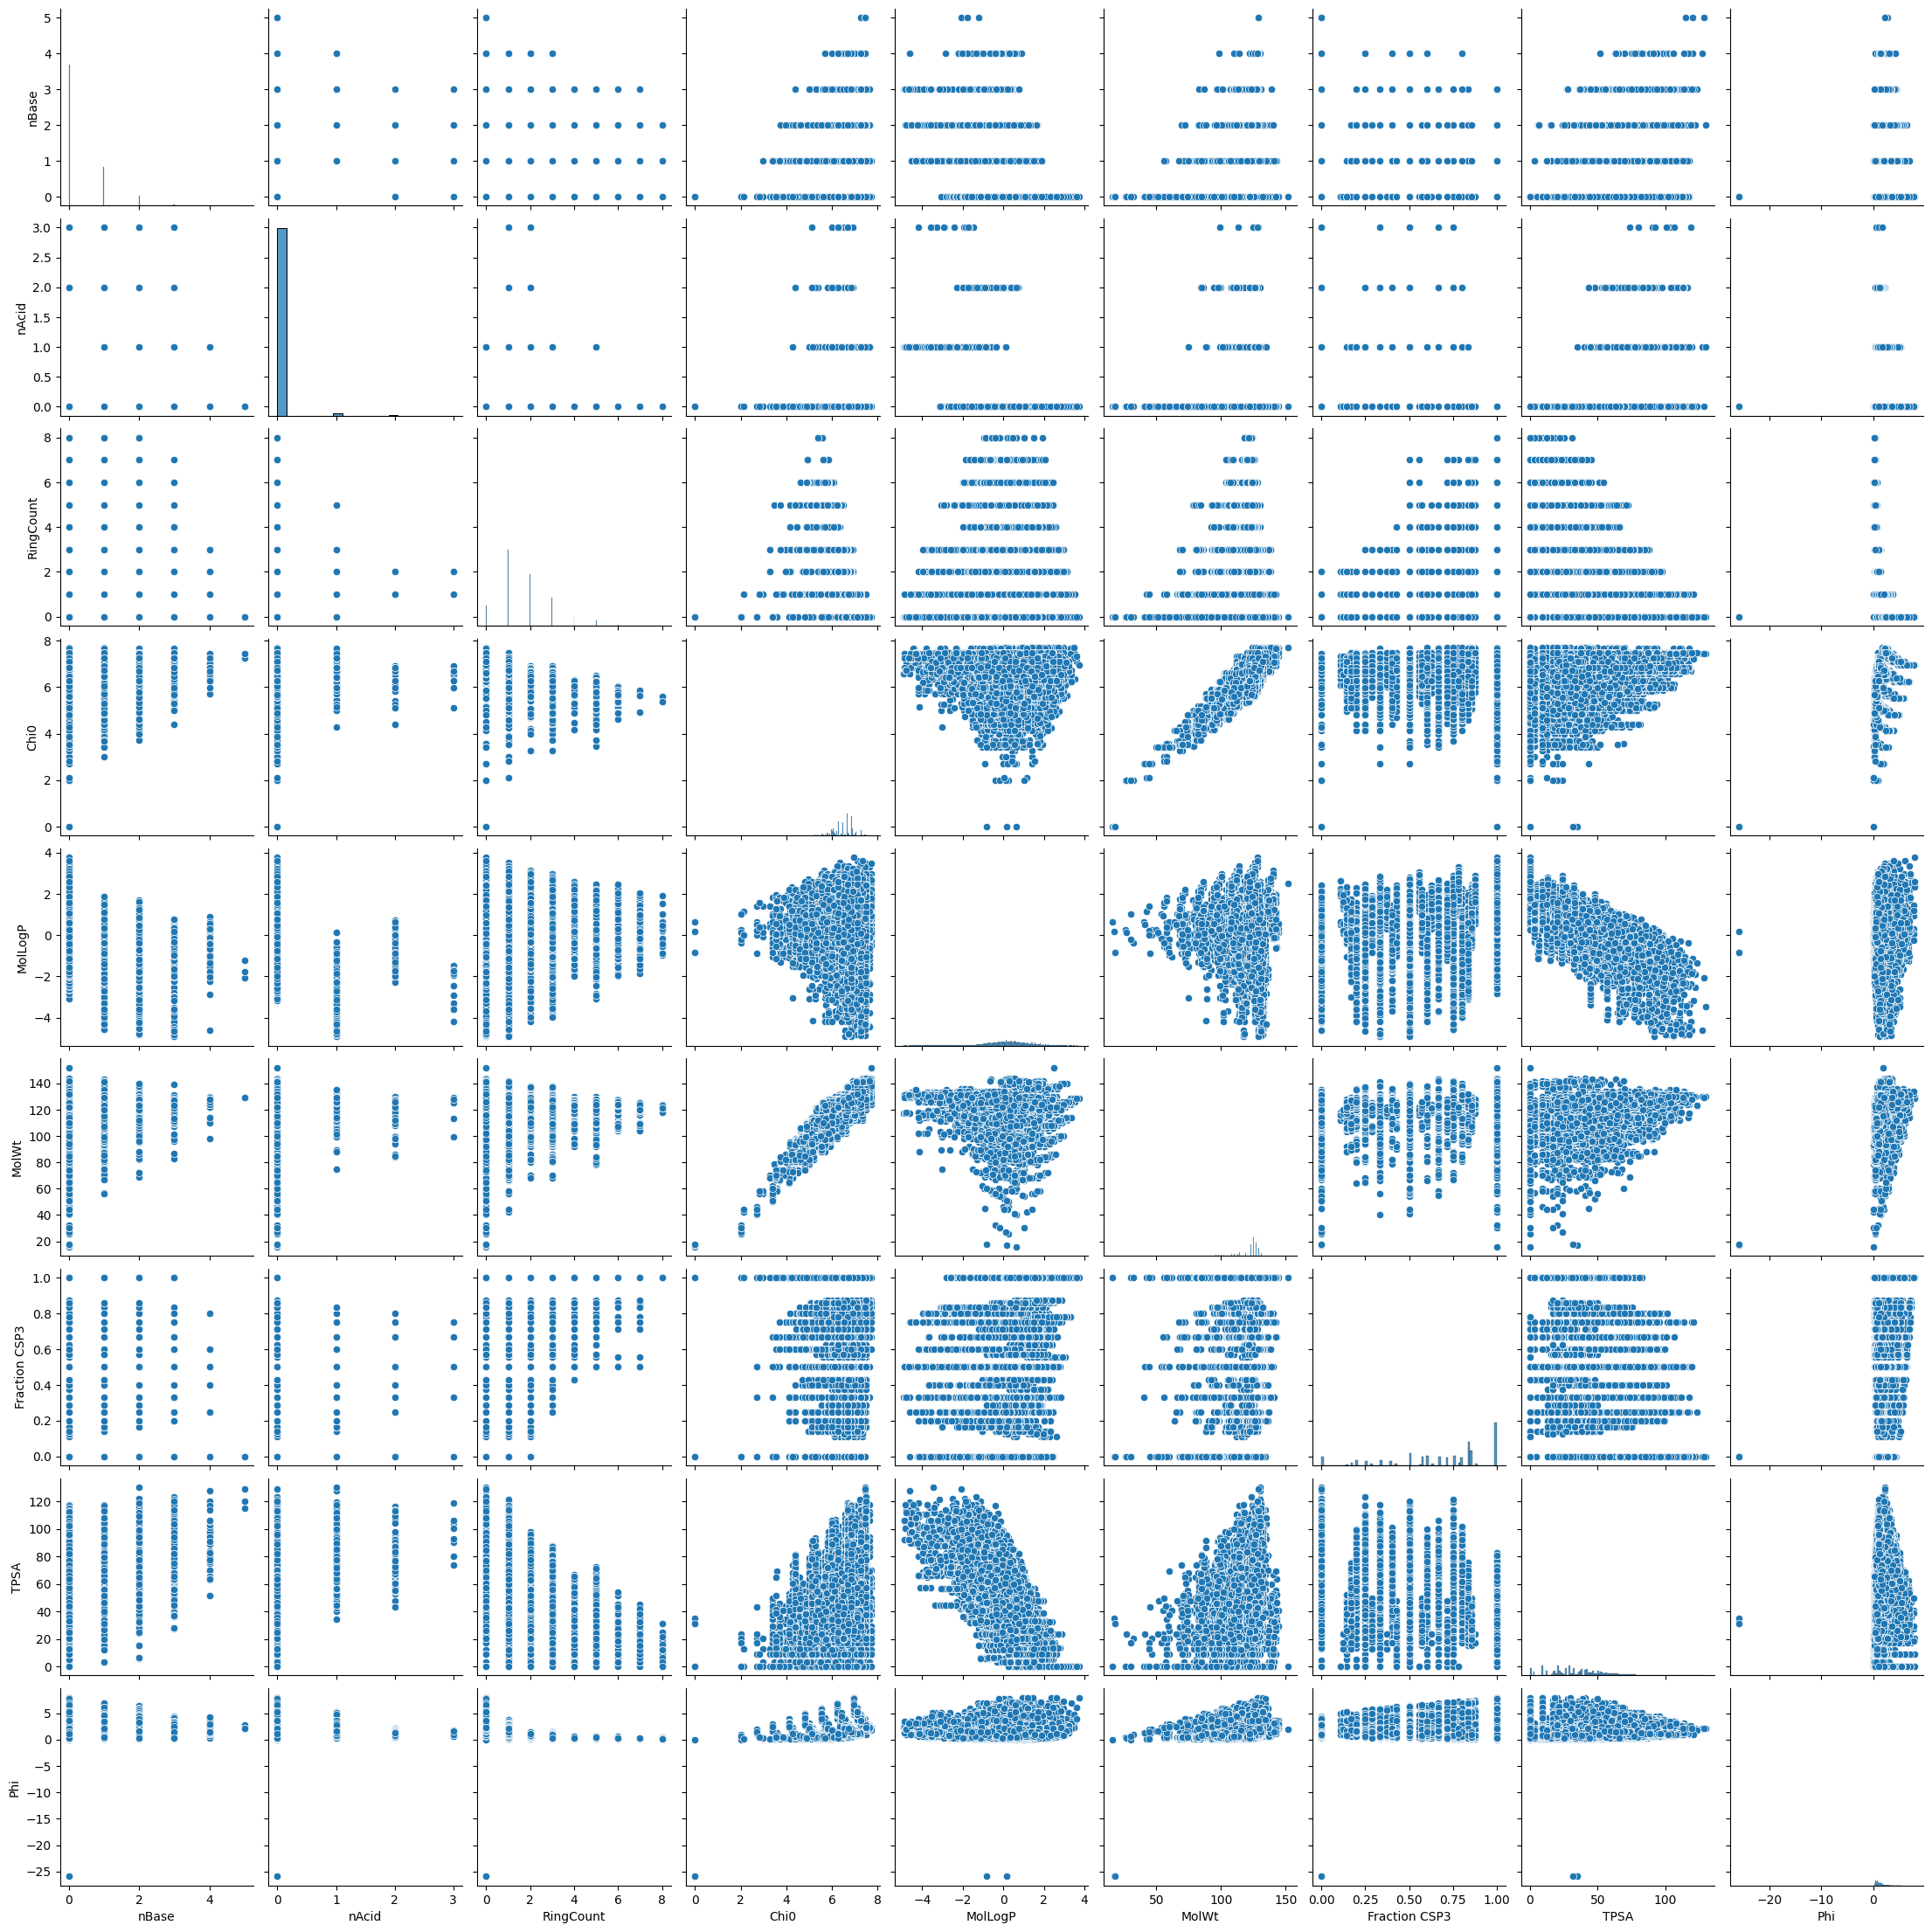

In [11]:
plt.figure(figsize=(15,30))
sns.pairplot(df[['nBase', 'nAcid', 'RingCount', 'Chi0', 'MolLogP', 'MolWt', 'Fraction CSP3', 'TPSA', 'Phi']])
plt.show()

### II. Use the feature vectors for 2 clusters algorithms

Thinking of using the **K-means algorithm** and **optics**.

Maybe using Phi and CHi0 as the feature vectors?

<Figure size 700x800 with 0 Axes>

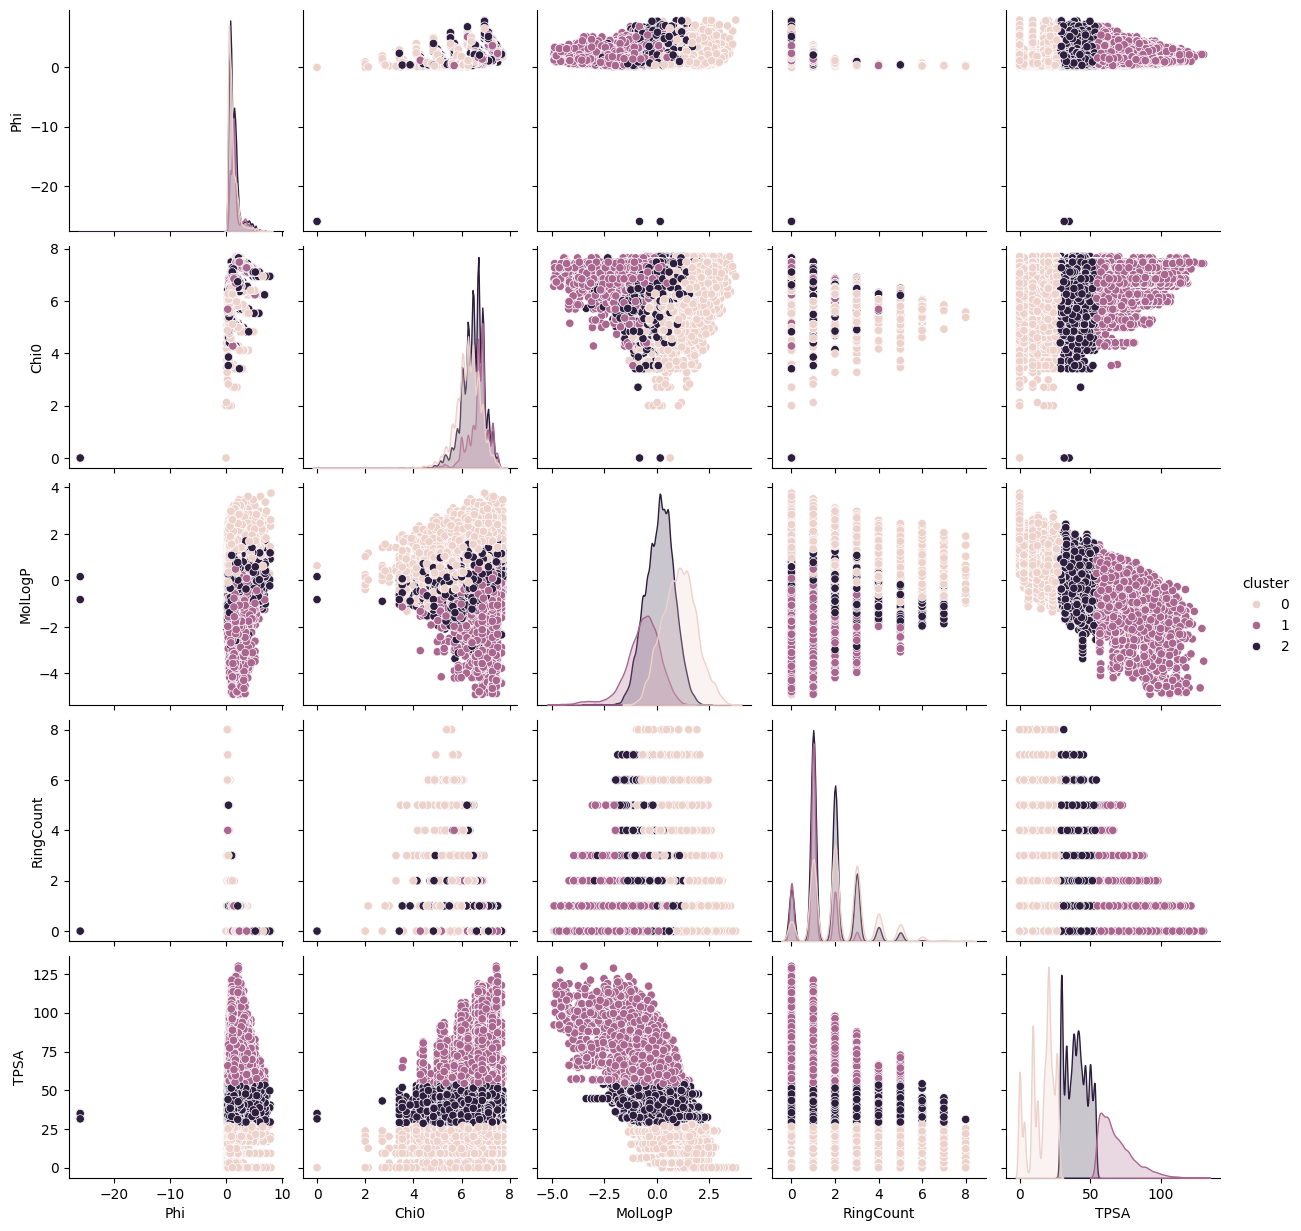

In [29]:
from sklearn.cluster import KMeans, OPTICS
import matplotlib.pyplot as plt
import seaborn as sns

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_clusters and random_state for reproducibility, and n_init
result = kmeans.fit_predict(df[['Phi', 'Chi0','MolLogP','RingCount', 'TPSA']])

# Add the cluster results to the DataFrame
df['cluster'] = result

plt.figure(figsize=(7,8))
sns.pairplot(df[['Phi', 'Chi0','MolLogP','RingCount', 'TPSA', 'cluster']], hue='cluster')
plt.show()